In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
from botorch.test_functions.multi_fidelity import AugmentedHartmann,AugmentedBranin
import torch
torch.set_printoptions(precision=3, sci_mode=False)   
from scipy.interpolate import Rbf
#from utilis import *

In [37]:
a = torch.tensor([0.701], dtype=torch.float64)

In [38]:
a.numpy()

array([0.701])

In [2]:
tkwargs = {
    "dtype":  torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Branin

In [3]:
from __future__ import annotations

import math
from typing import Optional

import torch
from botorch.test_functions.synthetic import SyntheticTestFunction
from torch import Tensor


class AugmentedBranin_modified(SyntheticTestFunction):
    r"""Augmented Branin test function for multi-fidelity optimization.

    3-dimensional function with domain `[-5, 10] x [0, 15] * [0,1]`, where
    the last dimension of is the fidelity parameter:

        B(x) = (x_2 - (b - 0.1 * (1 - x_3))x_1^2 + c x_1 - r)^2 +
            10 (1-t) cos(x_1) + 10

    Here `b`, `c`, `r` and `t` are constants where `b = 5.1 / (4 * math.pi ** 2)`
    `c = 5 / math.pi`, `r = 6`, `t = 1 / (8 * math.pi)`.
    B has infinitely many minimizers with `x_1 = -pi, pi, 3pi`
    and `B_min = 0.397887`
    """

    dim = 3
    _bounds = [(-5.0, 10.0), (0.0, 15.0), (0.0, 1.0)]
    _optimal_value = 0.397887
    _optimizers = [  # this is a subset, ther are infinitely many optimizers
        (-math.pi, 12.275, 1),
        (math.pi, 1.3867356039019576, 0.1),
        (math.pi, 1.781519779945532, 0.5),
        (math.pi, 2.1763039559891064, 0.9),
    ]
    
    SD = 1.5
    Scale = 10
    
    def set_SD(self,SD):
        self.SD = SD
        print("\nSetting the SD to : %f\n"%self.SD)
    
    def set_Scale(self,Scale):
        self.Scale = Scale
        print("\nSetting the Scale to : %f\n"%self.Scale)
        
    def evaluate_true(self, X: Tensor) -> Tensor:
        t1 = (
            X[..., 1]
            - (5.1 / (4 * math.pi ** 2) - 0.1 * (1 - X[:, 2])) * X[:, 0] ** 2
            + 5 / math.pi * X[..., 0]
            - 6
        )
        t2 = 10 * (1 - 1 / (8 * math.pi)) * torch.cos(X[..., 0])
        
        original_branin = t1 ** 2 + t2 + 10
        
        domain_corner  = torch.tensor([2.5,7.5],   dtype=torch.double)
        global_max     = torch.tensor([9.425,2.475],dtype=torch.double)

        mean           = domain_corner - (domain_corner -  global_max)*X[:,2].unsqueeze(-1)
        mean           = mean.numpy()
        cov            = [[self.SD,0],[0,self.SD]]
        points         = X[:,0:2].numpy()
        gaussian_weights = torch.tensor([0]*X.size()[0], dtype=torch.double)

        for idx,val in enumerate(points):
            point   = points[idx]
            mean_pt = mean[idx]
            gaussian_weights[idx] = multivariate_normal.pdf(point,mean_pt,cov)
            
        #we are working with inverted branin, so negate the original branin and add weigths    
        modified_branin = -1*original_branin + self.Scale * gaussian_weights
        
        return modified_branin

In [26]:
def plotBranin(SD=None, Scale = None, Plot_trajectory = None):
    
    test_prob = AugmentedBranin_modified().to(**tkwargs)
    bounds = test_prob.bounds
    
    if SD is None:
        print("\nSD argument not passed, seeting SD to 1.5")
        SD = 1.5
    test_prob.set_SD(SD)
        
    
    if Scale is None:
        print("\nScale argument not passed, seeting Scale to 100")
        Scale = 1
    test_prob.set_Scale(Scale)


    #discretization for sample space Nf*Nf    
    Nf = 75
    
    #Number of fidelity level
    s_list = np.linspace(0,1,16)

    xv, yv = np.meshgrid(np.linspace(bounds[0,0], bounds[1,0], Nf),
                         np.linspace(bounds[0,1], bounds[1,1], Nf))
    #print(xv.shape)

    xfine = np.hstack((np.atleast_2d(xv.flatten()).T,
                       np.atleast_2d(yv.flatten()).T))
    
    test_X = torch.tensor(xfine, dtype=torch.double)
    
    if Plot_trajectory == True:
        max_index_list = []

    # select the plot layout, grid 4*4
    f, ax = plt.subplots(4, 4, figsize=(10, 10), constrained_layout=True)

    for index,s in enumerate(s_list):

        print("\nRunning for Fidelity=%f\n"%s)
        temp = s*torch.ones((test_X.shape[0], 1))
        augment_test_X = torch.cat((test_X, temp), 1)
        test_Y = test_prob(augment_test_X)
        
        # find the position of first max value
        max_index = test_Y.numpy().argmax()
        
        if Plot_trajectory == True:
            #Find the position of  max values
            max_index_list.append(max_index)
        
        # Alias for plotting the grid
        row = index//4
        col = index - 4*row 

        # plot the  marker
        global_max = xfine[max_index]
        ax[row][col].plot(global_max[0], global_max[1], ls='', marker='*', markersize=10, color='k')

        # plot the contour
        z = np.reshape(test_Y, [Nf, Nf])
        c = ax[row][col].contourf(xv, yv, z, 25)
        ax[row][col].contour(xv, yv, z, 25, linestyles='solid', linewidths=.5,colors='k')
        ax[row][col].plot(*xfine[max_index], ls='', marker='x', c='k', markersize=10, label='global max')
        ax[row][col].title.set_text('s = %1.2f,  \n Max_value(Star) = \n%1.3f' %(s,test_Y[max_index]))        
        
    ax[0][0].legend()
    plt.colorbar(c)
    plt.show()


    if Plot_trajectory == True:
        fig, ax2 = plt.subplots()
        z = np.reshape(test_Y.numpy(), [Nf, Nf])
        ax2.contour(xv, yv, z, 25, linestyles='solid', linewidths=.5, colors='k')
        c = ax2.contourf(xv, yv, z, 25)
        for max_index in max_index_list:
            ax2.plot(*test_X[max_index], ls='', marker='x', c='k', markersize=10, label='global max.')
        ax2.set_title("Trajectory of Global maximum with \n fidelity level 0-->1\n X = Global_max")
        plt.colorbar(c)
        plt.show()
        


Setting the SD to : 1.500000


Setting the Scale to : 1000.000000


Running for Fidelity=0.000000


Running for Fidelity=0.066667


Running for Fidelity=0.133333


Running for Fidelity=0.200000


Running for Fidelity=0.266667


Running for Fidelity=0.333333


Running for Fidelity=0.400000


Running for Fidelity=0.466667


Running for Fidelity=0.533333


Running for Fidelity=0.600000


Running for Fidelity=0.666667


Running for Fidelity=0.733333


Running for Fidelity=0.800000


Running for Fidelity=0.866667


Running for Fidelity=0.933333


Running for Fidelity=1.000000



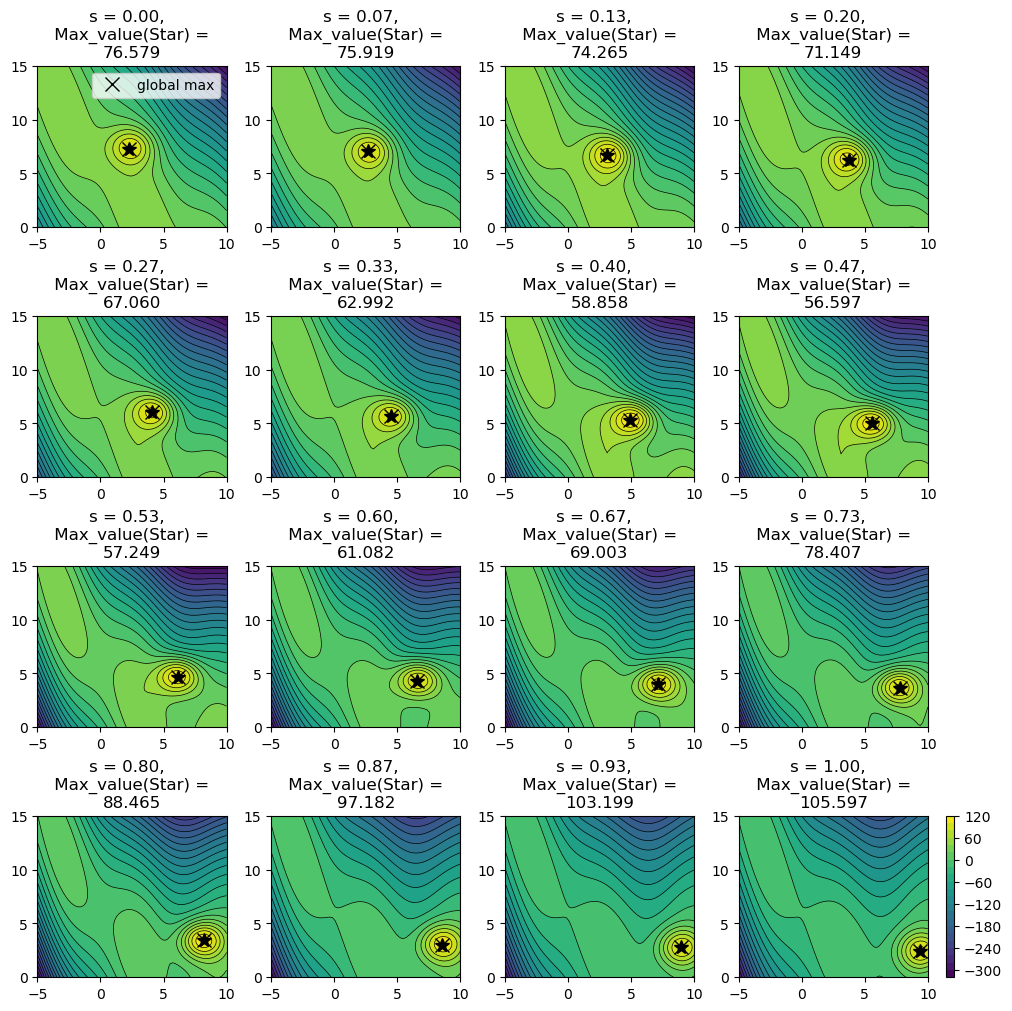

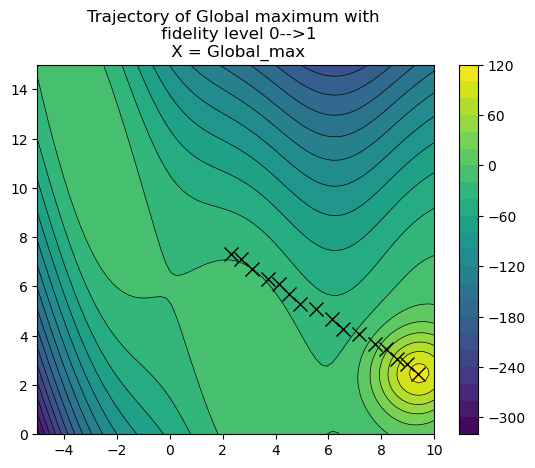

In [27]:
plotBranin(SD = 1.5, Scale=1000, Plot_trajectory=True)

# Currin 

In [28]:
import math
from typing import Optional

import torch
from torch import Tensor
import numpy as np
from botorch.test_functions.synthetic import SyntheticTestFunction
from scipy.stats import multivariate_normal

class AugmentedCurrin(SyntheticTestFunction):
    
    r"""Augmented Currin test function for multi-fidelity optimization.

    3-dimensional function with domain `[0, 1] x [0, 1] * [0,1]`, where
    the last dimension of is the fidelity parameter:

        a(x) = (1-e(-1/2x_2))*( (2300*x_1^3 + 1900*x_1^2 + 2092*x_1 + 60)/(100*x_1^3 + 500*x_1^2 + 4x_1 + 20))
        f(x) = PDF( a(x), N(x3,[[1.5,0],[0,1.5]]) )
        
    optimal_value = 119.901
    optimizer = [0.216,0]
    
    """

    dim = 3
    _bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
    _optimal_value = 119.901
    _optimizers = [(0.2160804, 0),]
    SD = 1.5
    Scale = 1000
    
    def set_SD(self,SD):
        self.SD = SD
        print("\nSetting the SD to : %f\n"%self.SD)
    
    def set_Scale(self,Scale):
        self.Scale = Scale
        print("\nSetting the Scale to : %f\n"%self.Scale)
        
    def evaluate_true(self, X: Tensor) -> Tensor:
     
        first_term  = (1 - torch.exp(-1/(2*X[:,1])))
        second_term = 2300*torch.pow(X[:,0],3) + 1900*torch.pow(X[:,0],2) + 2092*X[:,0] + 60
        third_term  = 100*torch.pow(X[:,0],3)  + 500*torch.pow(X[:,0],2)  + 4*X[:,0]    + 20

        original_currin = (first_term * second_term) / (third_term)

        domain_corner  = torch.tensor([1,1],   dtype=torch.double)
        global_max     = torch.tensor([0.21,0],dtype=torch.double)

        mean           = 1 - (domain_corner -  global_max)*X[:,2].unsqueeze(-1)
        mean           = mean.numpy()
        cov            = [[self.SD,0],[0,self.SD]]
        points         = X[:,0:2].numpy()
        gaussian_weights = torch.tensor([0]*X.size()[0], dtype=torch.double)

        for idx,val in enumerate(points):
            point   = points[idx]
            mean_pt = mean[idx]
            gaussian_weights[idx] = multivariate_normal.pdf(point,mean_pt,cov)

        modified_currin = original_currin + self.Scale * gaussian_weights
        
        return modified_currin/100

In [29]:
def plotCurrin(SD=None, Scale = None, Plot_trajectory = None):
    
    
    test_prob = AugmentedCurrin().to(**tkwargs)
    bounds = test_prob.bounds
    
    if SD is None:
        print("\nSD argument not passed, seeting SD to 1.5")
        SD = 1.5
    test_prob.set_SD(SD)
        
    
    if Scale is None:
        print("\nScale argument not passed, seeting Scale to 100")
        Scale = 1000
    test_prob.set_Scale(Scale)


    #discretization for sample space Nf*Nf    
    Nf = 75
    
    #Number of fidelity level
    s_list = np.linspace(0,1,16)

    xv, yv = np.meshgrid(np.linspace(bounds[0,0], bounds[1,0], Nf),
                         np.linspace(bounds[0,1], bounds[1,1], Nf))
    #print(xv.shape)

    xfine = np.hstack((np.atleast_2d(xv.flatten()).T,
                       np.atleast_2d(yv.flatten()).T))
    
    test_X = torch.tensor(xfine, dtype=torch.double)
    
    if Plot_trajectory == True:
        max_index_list = []

    #Select the plot layout, grid 4*4
    f, ax = plt.subplots(4, 4, figsize=(10, 10),constrained_layout=True)

    for index,s in enumerate(s_list):

        print("\nRunning for Fidelity=%f\n"%s)
        temp = s*torch.ones((test_X.shape[0], 1))
        augment_test_X = torch.cat((test_X, temp), 1)
        test_Y = test_prob(augment_test_X)
        
        #Find the position of first max value
        max_index = test_Y.numpy().argmax()
        
        
        if Plot_trajectory == True:
            #Find the position of first max value
            max_index_list.append(max_index)
        
        # Alias for plotting the grid
        row = index//4
        col = index - 4*row 

        #plot the  marker
        global_max = xfine[max_index]
        ax[row][col].plot(global_max[0], global_max[1], ls='', marker='*', markersize=10, color='k')

        #plot the contour
        z = np.reshape(test_Y, [Nf, Nf])
        c = ax[row][col].contourf(xv, yv, z, 25)
        ax[row][col].contour(xv, yv, z, 25, linestyles='solid', linewidths=.5,colors='k')
        ax[row][col].plot(*xfine[max_index], ls='', marker='x', c='k', markersize=10, label='global max')
        ax[row][col].title.set_text('s = %1.2f,  \n Max_value(Star) = \n%1.3f' %(s,test_Y[max_index]))        

    ax[0][0].legend()
    plt.colorbar(c)
    plt.show()


    if Plot_trajectory == True and s==1:
        fig, ax2 = plt.subplots()
        z = np.reshape(test_Y.numpy(), [Nf, Nf])
        ax2.contour(xv, yv, z, 25, linestyles='solid', linewidths=.5,colors='k')
        c = ax2.contourf(xv, yv, z, 25)
        for max_index in max_index_list:
            ax2.plot(*test_X[max_index], ls='', marker='x', c='k', markersize=10, label='global max.')
        ax2.set_title("Trajectory of Global maximum with \n fidelity level 0-->1\n X = Global_max")
        plt.colorbar(c)
        plt.show()



Setting the SD to : 2.000000


Setting the Scale to : 1000.000000


Running for Fidelity=0.000000


Running for Fidelity=0.066667


Running for Fidelity=0.133333


Running for Fidelity=0.200000


Running for Fidelity=0.266667


Running for Fidelity=0.333333


Running for Fidelity=0.400000


Running for Fidelity=0.466667


Running for Fidelity=0.533333


Running for Fidelity=0.600000


Running for Fidelity=0.666667


Running for Fidelity=0.733333


Running for Fidelity=0.800000


Running for Fidelity=0.866667


Running for Fidelity=0.933333


Running for Fidelity=1.000000



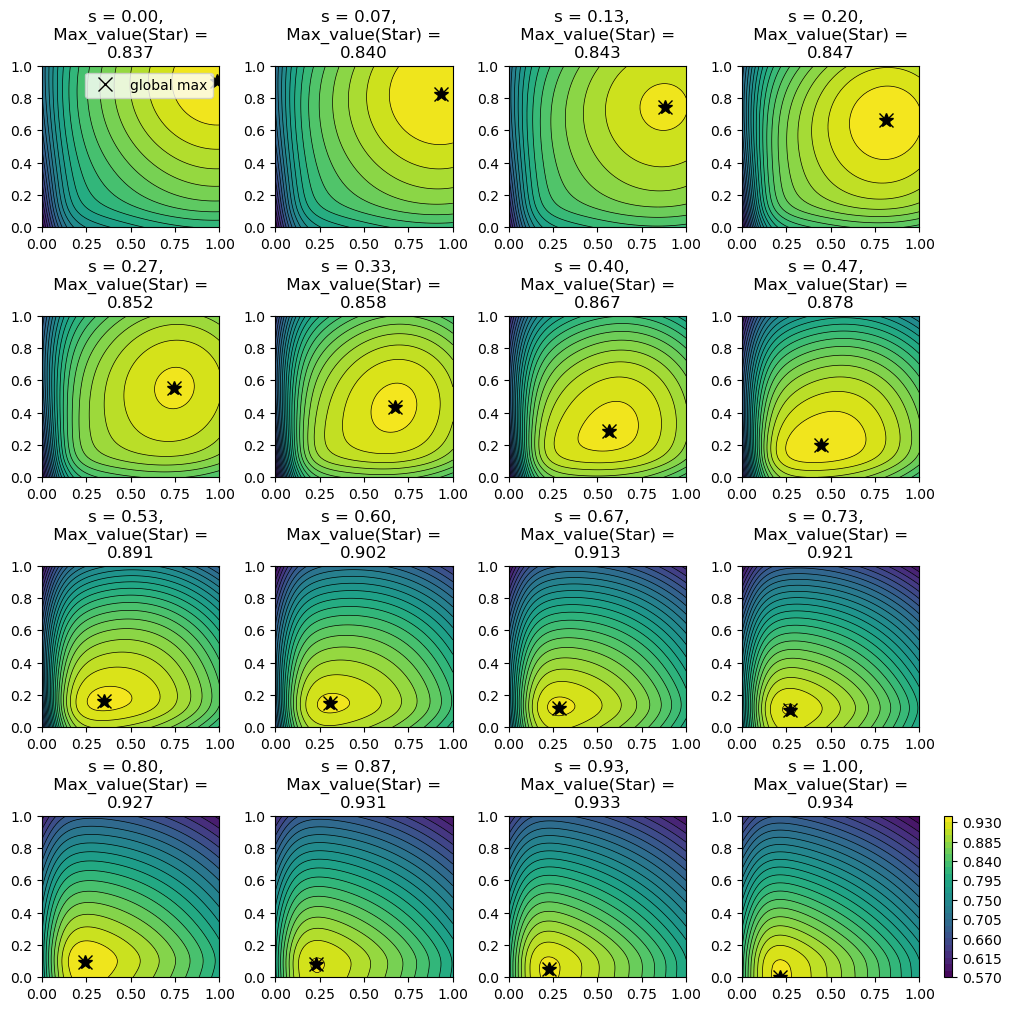

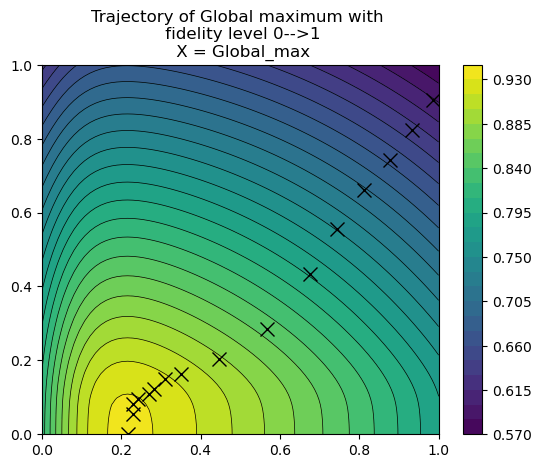

In [30]:
plotCurrin(SD=2, Scale=1000, Plot_trajectory=True)

# Hartmann

In [31]:
def PlotHartman():

    test_prob = AugmentedHartmann(negate=True).to(**tkwargs)
    bounds = test_prob.bounds

    print("\nRunning For test function %s\n"%str(test_prob))

    #discretization for sample space Nf*Nf    
    Nf = 75

    xv, yv = np.meshgrid(np.linspace(0,1,Nf),np.linspace(0,1,Nf))

    xfine = np.hstack((np.atleast_2d(xv.flatten()).T,
                       np.atleast_2d(yv.flatten()).T))

    test_X = np.ones(shape = (xfine.shape[0],test_prob.dim-1)) #create a test_X of dim-1, will add the column for fidelity later in loop
    test_X = torch.tensor(test_X, dtype=torch.float32) 


    #Select the plot layout, grid nrow*ncols
    nrows  = 3
    ncols  = 4
    f, ax = plt.subplots(nrows, ncols, figsize=(15, 10),constrained_layout=True)

    #Number of fidelity level
    s_list = np.linspace(0,1,ncols)

    true_global_maximum = np.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
    true_global_maximum = torch.tensor(true_global_maximum, dtype=torch.float32) 

    for row in range(nrows): 

        if row == 0:
            variable_columns = [0,1] #The first row of plots will vary 0th and 1st columns, while keeping the rest fixed at value of their respective golbal minima
            fix_columns      = [2,3,4,5]
        elif row == 1:
            variable_columns = [2,3] #The second row of plots will vary 2nd and 3rd column, while keeping the rest fixed at value of their respective golbal minima
            fix_columns      = [0,1,4,5]
        else:
            variable_columns = [4,5] #The thrid row of plots will vary 4th and 5th columns, while keeping the rest fixed at value of their respective golbal minima
            fix_columns      = [0,1,2,3]

        #set the variable column
        augment_test_X = test_X.clone().detach()
        augment_test_X[:,variable_columns[0]] = augment_test_X[:,variable_columns[0]]*xfine[:,0]
        augment_test_X[:,variable_columns[1]] = augment_test_X[:,variable_columns[1]]*xfine[:,1]


        #set the rest of them to a fixed value=0.5
        augment_test_X[:,fix_columns] = augment_test_X[:,fix_columns]*true_global_maximum[fix_columns]


        for col in range(ncols):

            print("\nRunning for Fidelity=%f and variable columns: %s\n"%(s_list[col],str(variable_columns)))

            #Concatnate Fidelity `s` to test_x and feed it to test function
            temp = s_list[col]*torch.ones((test_X.shape[0], 1))
            augment_test_X_with_fidelity = torch.cat((augment_test_X, temp), 1)


            test_Y = test_prob(augment_test_X_with_fidelity).unsqueeze(-1)
            test_Y = test_Y.numpy()


            max_index = test_Y.argmax()

            global_max = xfine[max_index]

            ax[row][col].plot(global_max[0], global_max[1], ls='', marker='*', markersize=10, color='k')

            #plot the contour
            z = np.reshape(test_Y, [Nf, Nf])
            c = ax[row][col].contourf(xv, yv, z)
            ax[row][col].contour(xv, yv, z, 25, linestyles='solid', linewidths=.5, colors='k')
            ax[row][col].title.set_text('s = %f,\nglobal_maximum = %f\nvariable = %s'%(s_list[col],test_Y[max_index][0],str(variable_columns)))

            del augment_test_X_with_fidelity

        del augment_test_X
    cbar = f.colorbar(c)    
    plt.show()


Running For test function AugmentedHartmann()


Running for Fidelity=0.000000 and variable columns: [0, 1]


Running for Fidelity=0.333333 and variable columns: [0, 1]


Running for Fidelity=0.666667 and variable columns: [0, 1]


Running for Fidelity=1.000000 and variable columns: [0, 1]


Running for Fidelity=0.000000 and variable columns: [2, 3]


Running for Fidelity=0.333333 and variable columns: [2, 3]


Running for Fidelity=0.666667 and variable columns: [2, 3]


Running for Fidelity=1.000000 and variable columns: [2, 3]


Running for Fidelity=0.000000 and variable columns: [4, 5]


Running for Fidelity=0.333333 and variable columns: [4, 5]


Running for Fidelity=0.666667 and variable columns: [4, 5]


Running for Fidelity=1.000000 and variable columns: [4, 5]



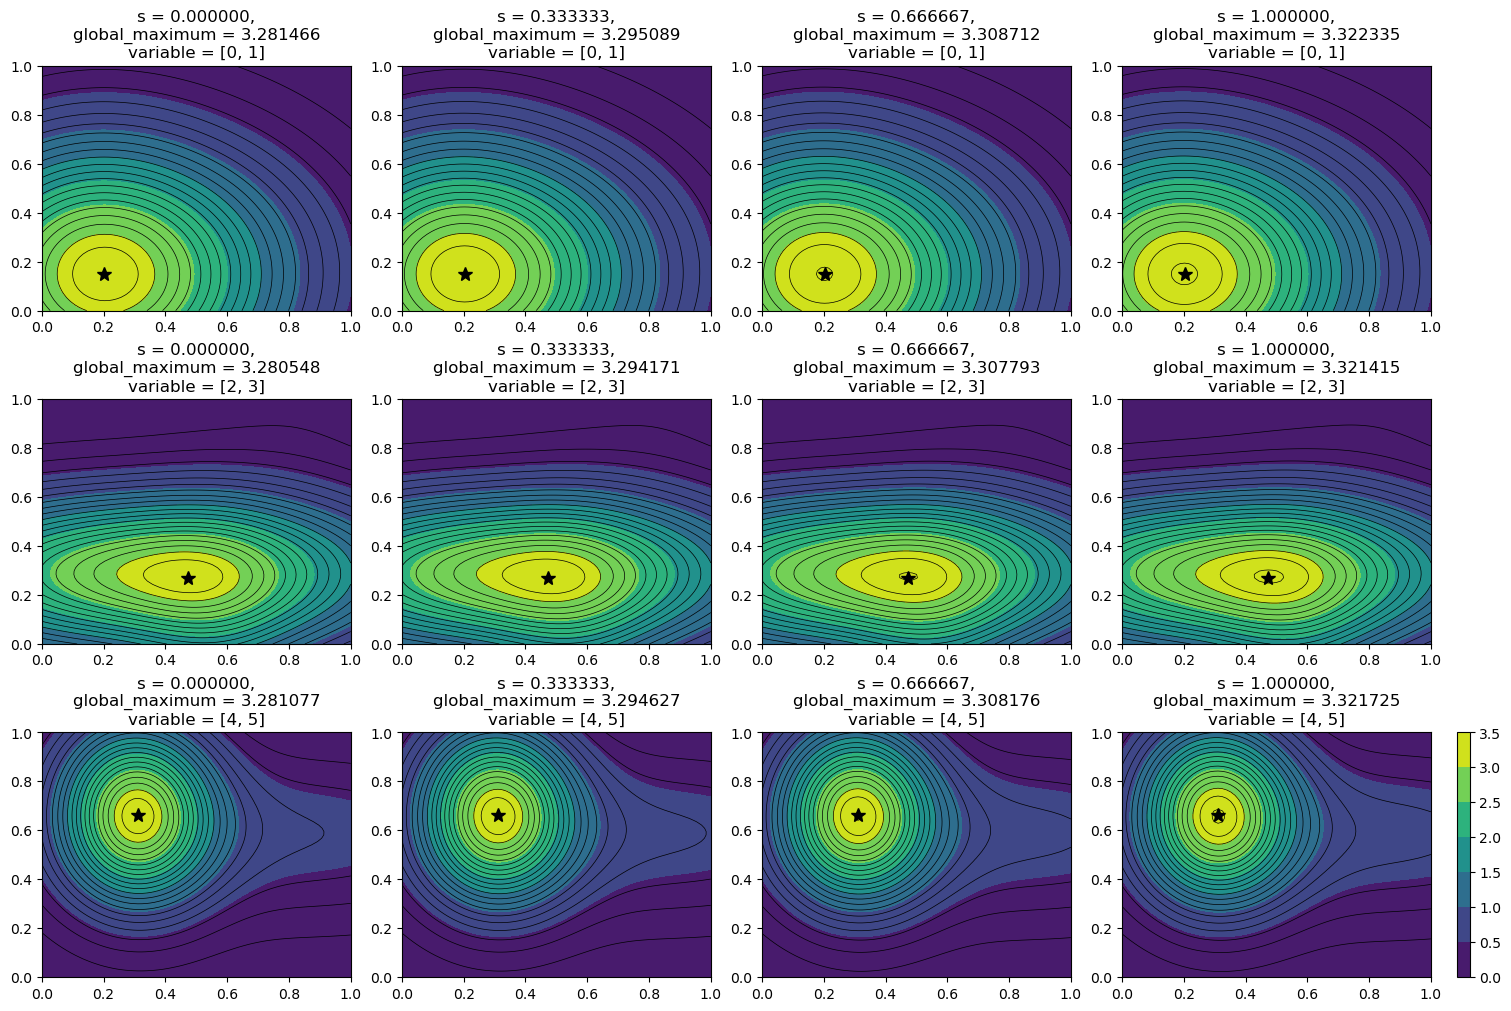

In [32]:
PlotHartman()

# Forrestor

In [33]:
import math
from typing import Optional

import torch
from torch import Tensor
import numpy as np
from botorch.test_functions.synthetic import SyntheticTestFunction
from scipy.stats import multivariate_normal

class AugmentedForrestor(SyntheticTestFunction):
    
    r"""Augmented Forrestor test function for multi-fidelity optimization.

    2-dimensional function with domain `[0, 1] * [0,1]`, where
    the last dimension of is the fidelity parameter:

  
    f(x) = -( (6x-2)*sin(12x-4) + (10-s*10)(x-0.5) + 20(1-s) )
    s is the fidelity.
    optimal_value = 6.02
    optimizer = 0.7587
    
    """

    dim = 2
    _bounds = [(0.0, 1.0), (0.0, 1.0)]
    _optimal_value = 6.02
    _optimizers = [0.7587]

    def evaluate_true(self, X: Tensor) -> Tensor:     
        x = X[:,0]
        s = X[:,1]
        temp = -1*(torch.square(6*x-2)*torch.sin(12*(x)-4) + (10-s*10)*(x-0.5) + 20*(1-s))
        return temp
    
class AugmentedForrestor_Negate(SyntheticTestFunction):
    
    r"""Augmented Forrestor test function for multi-fidelity optimization.

    2-dimensional function with domain `[0, 1] * [0,1]`, where
    the last dimension of is the fidelity parameter:

  
    f(x) = -( (6x-2)*sin(12x-4) + (10-s*10)(x-0.5) + 20(1-s) )
    s is the fidelity.
    optimal_value = 6.02
    optimizer = 0.7587
    
    """

    dim = 2
    _bounds = [(0.0, 1.0), (0.0, 1.0)]
    _optimal_value = 6.02
    _optimizers = [0.7587]

    def evaluate_true(self, X: Tensor) -> Tensor:     
        x = X[:,0]
        s = X[:,1]
        s = 1 - s
        temp = -1*(torch.square(6*x-2)*torch.sin(12*(x)-4) + (10-s*10)*(x-0.5) + 20*(1-s))
        return temp

In [34]:
def PlotForestor(negate=None):
    if negate is None:
        prob = AugmentedForrestor()
        print("\nRoutine Running for Forrestor\n")
    else:
        prob = AugmentedForrestor_Negate()
        print("\nRoutine Running for Inverted-Forrestor\n")
        
    x = np.linspace(0,1,200)
    test_x = torch.tensor(x,dtype=torch.float64).unsqueeze(-1)
    s_list = np.linspace(0,1,5)

    for s in s_list:    
        temp = s*torch.ones((len(test_x), 1))
        augment_test_X_with_fidelity = torch.cat((test_x, temp), 1)
        test_Y = prob(augment_test_X_with_fidelity).unsqueeze(-1)
        test_Y = test_Y.numpy()   
        plt.plot(x,test_Y,label="s = "+str(s))
        del augment_test_X_with_fidelity
        if s==1:
            global_max = test_Y.argmax()
            print(x[global_max],test_Y[global_max])
            plt.plot(x[global_max],test_Y[global_max] , ls='', marker='*', markersize=10, color='k')
            
    plt.legend()


Routine Running for Forrestor

0.7587939698492463 [6.01945945]


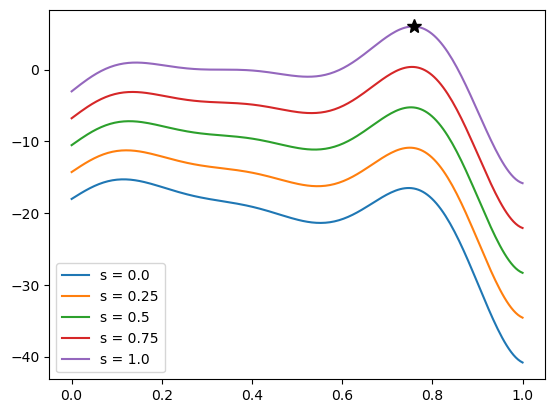

In [35]:
PlotForestor()